In [1]:
! git clone https://github.com/Shenggan/BCCD_Dataset.git

Cloning into 'BCCD_Dataset'...
remote: Enumerating objects: 800, done.
remote: Total 800 (delta 0), reused 0 (delta 0), pack-reused 800 (from 1)
Receiving objects: 100% (800/800), 7.39 MiB | 21.86 MiB/s, done.
Resolving deltas: 100% (378/378), done.


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
import shutil
import re
!pip install ultralytics
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.0/879.0 kB 24.1 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
image_dir = '/content/BCCD_Dataset/BCCD/JPEGImages'
df = pd.read_csv('/content/BCCD_Dataset/test.csv')

In [4]:
df.head()

,filename,cell_type,xmin,xmax,ymin,ymax
0,BloodImage_00000.jpg,WBC,260,491,177,376
1,BloodImage_00000.jpg,RBC,78,184,336,435
2,BloodImage_00000.jpg,RBC,63,169,237,336
3,BloodImage_00000.jpg,RBC,214,320,362,461
4,BloodImage_00000.jpg,RBC,414,506,352,445


In [5]:
class_map = {
    'RBC': (0, 0, 255),
    'WBC': (255, 0, 0),
    'Platelets': (0, 255, 0)
}


def display_sample_images_with_boxes(df, sample_filenames, image_folder='path_to_images'):
    for filename in sample_filenames:
        img_df = df[df['filename'] == filename]

        image_path = f"{image_folder}/{filename}"
        image = cv2.imread(image_path)
        if image is None:
            print(f"Image {filename} not found.")
            continue

        for _, row in img_df.iterrows():
            color = class_map.get(row['cell_type'])

            cv2.rectangle(image,
                          (row['xmin'], row['ymin']),
                          (row['xmax'], row['ymax']),
                          color, 2)

            cv2.putText(image, row['cell_type'],
                        (row['xmin'], row['ymin'] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, color, 1, cv2.LINE_AA)

        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"Detected cells in {filename}")
        plt.axis('off')
        plt.show()

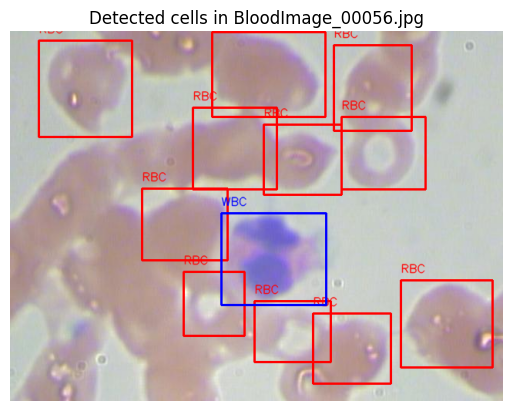

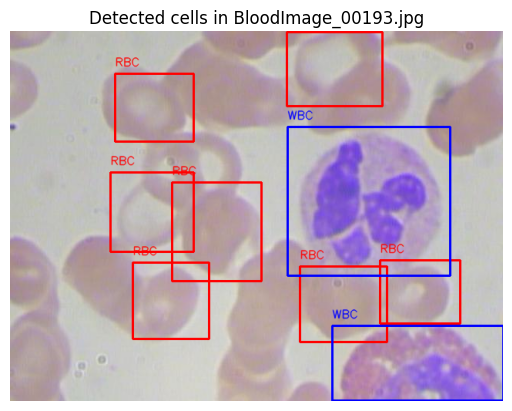

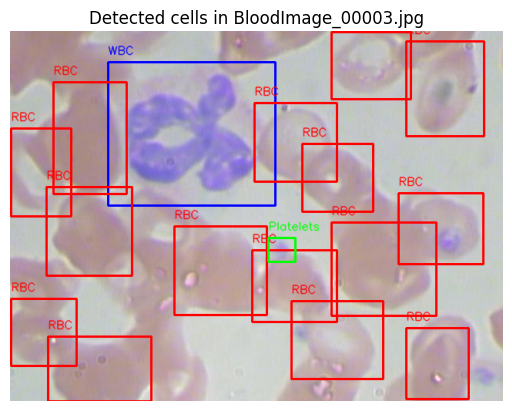

In [6]:
sample_filenames = df['filename'].drop_duplicates().sample(3)
display_sample_images_with_boxes(df, sample_filenames, image_dir)

In [7]:
base = 'Data'
output_image_path = os.path.join(base, 'images')
output_label_path = os.path.join(base, 'labels')

os.makedirs(output_image_path, exist_ok = True)
os.makedirs(output_label_path, exist_ok = True)

In [8]:
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(output_image_path, split), exist_ok = True)
    os.makedirs(os.path.join(output_label_path, split), exist_ok = True)

In [9]:
unique_filenames = df['filename'].unique()
train_files, test_files = train_test_split(unique_filenames, test_size=0.2, random_state=42)
train_files, val_files = train_test_split(train_files, test_size=0.25, random_state=42)

In [10]:
class_mapping = {
    'WBC': 0,
    'RBC': 1,
    'Platelets': 2
}

def convert_to_yolo(row, img_width, img_height):
    cell_type = row['cell_type']
    class_id = class_mapping.get(cell_type, -1)

    if class_id == -1:
        print(f"Warning: Class for cell type '{cell_type}' not found.")
        return ""

    x_center = (row['xmin'] + row['xmax']) / 2 / img_width
    y_center = (row['ymin'] + row['ymax']) / 2 / img_height
    width = (row['xmax'] - row['xmin']) / img_width
    height = (row['ymax'] - row['ymin']) / img_height

    return f"{class_id} {x_center} {y_center} {width} {height}\n"

In [11]:
def process_split(file_list, split):
    for filename in file_list:
        src_image_path = os.path.join(image_dir, filename)
        dest_image_path = os.path.join(output_image_path, split, filename)
        shutil.copy(src_image_path, dest_image_path)

        image = cv2.imread(src_image_path)
        if image is None:
            print(f"Warning: Skipping corrupt image {filename}.")
            continue

        img_height, img_width = image.shape[:2]

        label_path = os.path.join(output_label_path, split, filename.replace('.jpg', '.txt'))
        with open(label_path, 'w') as label_file:
            for _, row in df[df['filename'] == filename].iterrows():
                yolo_format = convert_to_yolo(row, img_width, img_height)
                if yolo_format:
                    label_file.write(yolo_format)

In [12]:
process_split(train_files, 'train')
process_split(val_files, 'val')
process_split(test_files, 'test')

In [14]:
!yolo task = detect mode = train data = data_config.yaml model = yolov10m.pt imgsz = 640 epochs = 200

100% 32.1M/32.1M [00:00<00:00, 113MB/s]
Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov10m.pt, data=data_config.yaml, epochs=200, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels